Loading data...
  Processing historical...
  Processing ssp126...
  Processing ssp245...
  Processing ssp585...
  Processing g6sulfur...
Data loading complete!

RMSE range: 0.00 to 54.30
RMSE mean: 1.47
RMSE 95th percentile: 3.94


/tmp/ipykernel_87068/4128705707.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)



Figure saved to: ../Figures/fig7.png


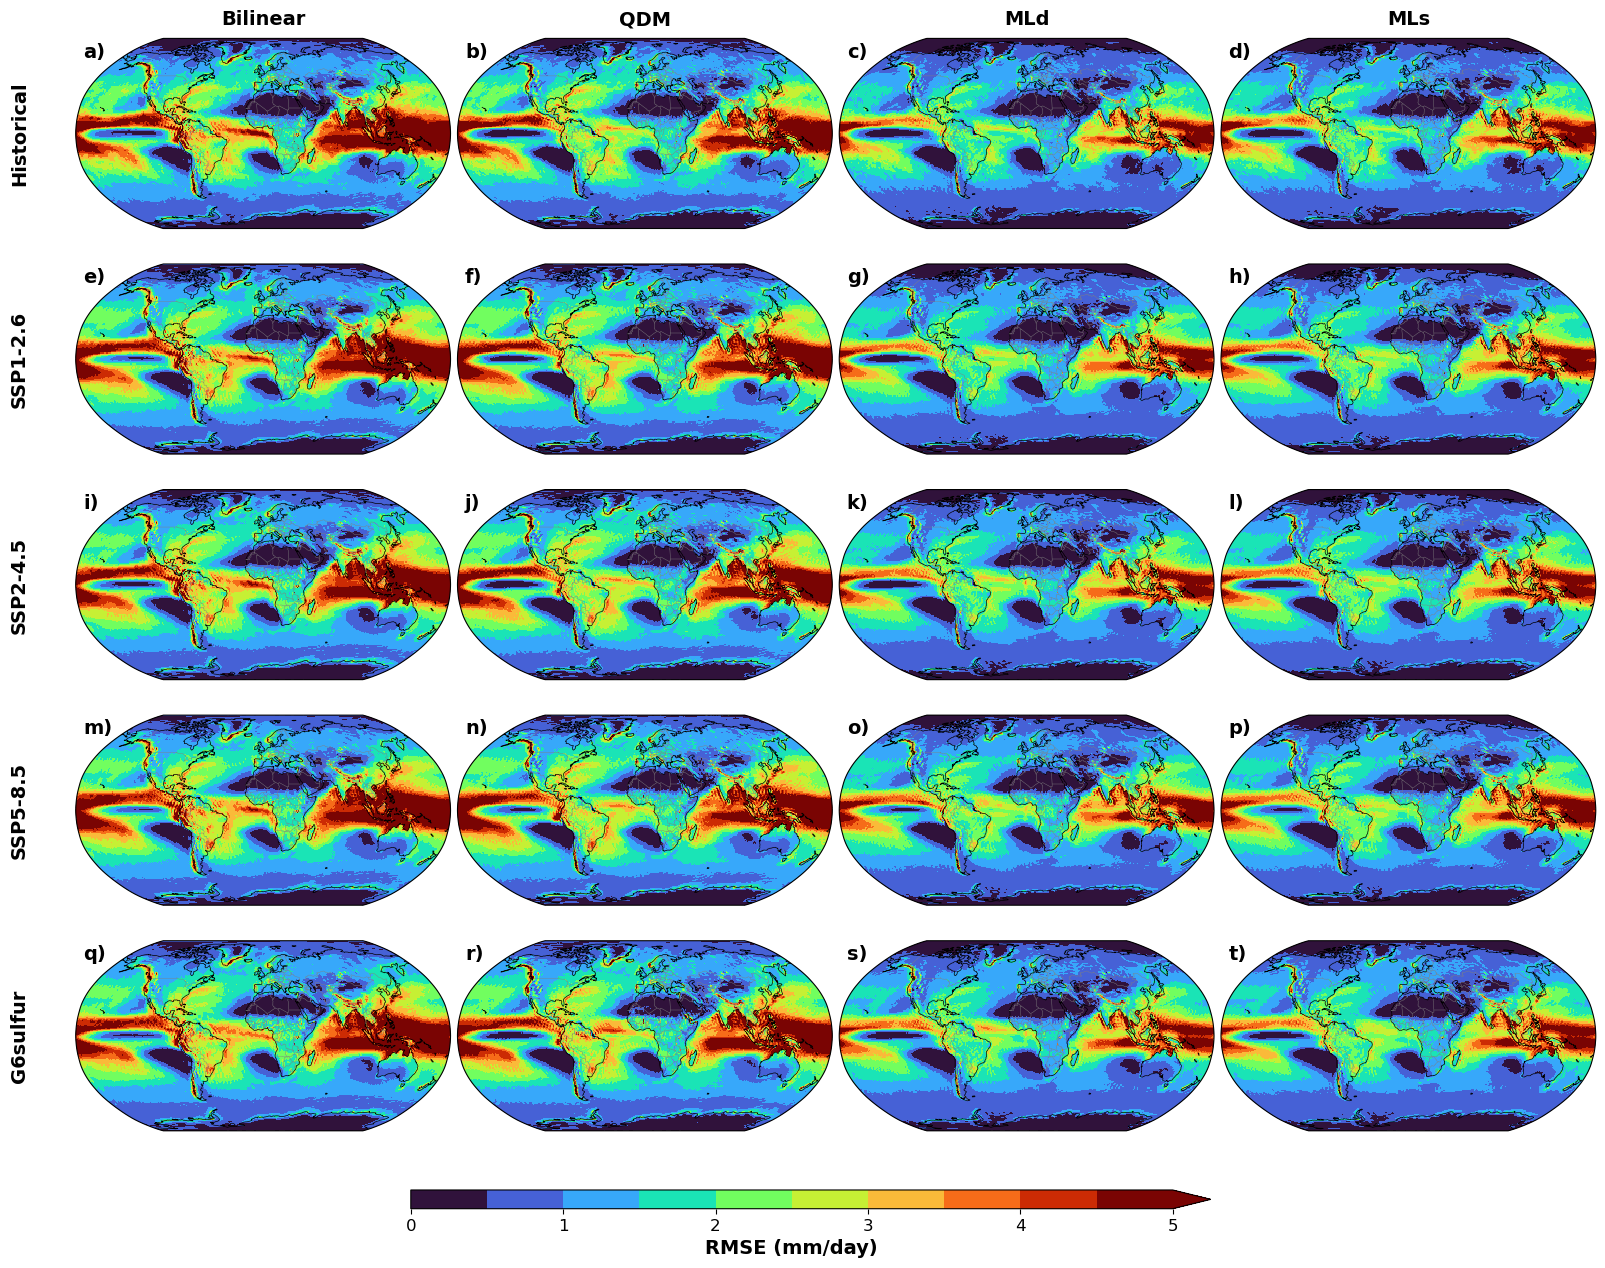

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'pr'  
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']  
scenario_labels = {
    'historical': 'Historical', 
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5',
    'g6sulfur': 'G6sulfur'
}

# Model configuration
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# ----------------------------
# Functions
# ----------------------------
def calculate_spatial_rmse(pred_data, truth_data):
    """Calculate RMSE at each spatial location over all time steps."""
    squared_error = (pred_data - truth_data) ** 2
    mean_squared_error = np.mean(squared_error, axis=0)
    rmse = np.sqrt(mean_squared_error)
    return rmse

# ----------------------------
# Load data and calculate RMSE
# ----------------------------
print("Loading data...")
rmse_maps = {scenario: {} for scenario in scenarios}
lat, lon = None, None

for scenario in scenarios:
    print(f"  Processing {scenario}...")
    
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    truth = ds_main['groundtruth'].values
    
    if lat is None:
        lat = ds_main.lat.values
        lon = ds_main.lon.values
    
    # Bilinear RMSE
    if 'input' in ds_main:
        rmse_maps[scenario]['bilinear'] = calculate_spatial_rmse(ds_main['input'].values, truth)
    
    # MLd RMSE (zscore_pixel)
    if 'pred_zscore_pixel' in ds_main:
        rmse_maps[scenario]['mld'] = calculate_spatial_rmse(ds_main['pred_zscore_pixel'].values, truth)
    
    ds_main.close()
    
    # Load QDM results
    qdm_file = results_dir / f"{var_name}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        
        if 'pred_qdm' in ds_qdm:
            truth_qdm = ds_qdm['groundtruth'].values
            rmse_maps[scenario]['qdm'] = calculate_spatial_rmse(ds_qdm['pred_qdm'].values, truth_qdm)
        
        ds_qdm.close()
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        
        if 'pred_grid' in ds_residual:
            truth_res = ds_residual['groundtruth'].values
            rmse_maps[scenario]['mls'] = calculate_spatial_rmse(ds_residual['pred_grid'].values, truth_res)
        
        ds_residual.close()

print("Data loading complete!")

# ----------------------------
# Check data range for setting appropriate colorbar limits
# ----------------------------
all_rmse = []
for scenario in scenarios:
    for model in models:
        if model in rmse_maps[scenario]:
            all_rmse.append(rmse_maps[scenario][model])
all_rmse_concat = np.concatenate([r.flatten() for r in all_rmse])
print(f"\nRMSE range: {np.nanmin(all_rmse_concat):.2f} to {np.nanmax(all_rmse_concat):.2f}")
print(f"RMSE mean: {np.nanmean(all_rmse_concat):.2f}")
print(f"RMSE 95th percentile: {np.nanpercentile(all_rmse_concat, 95):.2f}")

# ----------------------------
# Create 5x4 subplot figure 
# ----------------------------
fig = plt.figure(figsize=(16, 12.5))  

# Colormap settings - adjusted for precipitation (mm/day)
cmap = 'turbo'
rmse_vmin, rmse_vmax = 0, 5  # Adjusted for precipitation
rmse_levels = np.linspace(rmse_vmin, rmse_vmax, 11)
rmse_norm = BoundaryNorm(rmse_levels, ncolors=256)

# Panel labels
panel_labels = [f"{chr(97 + i)})" for i in range(20)]

# Create meshgrid for plotting
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Plot 5 rows (scenarios) x 4 columns (models)
for row_idx, scenario in enumerate(scenarios):
    for col_idx, model in enumerate(models):
        ax = fig.add_subplot(5, 4, row_idx * 4 + col_idx + 1, projection=ccrs.Robinson())
        
        rmse = rmse_maps[scenario][model]
        
        # Plot RMSE
        im = ax.pcolormesh(lon_2d, lat_2d, rmse,
                          transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=rmse_norm,
                          shading='auto')
        
        ax.coastlines(linewidth=0.5, color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
        ax.set_global()
        
        # Column title (top row only)
        if row_idx == 0:
            ax.set_title(model_labels[model], fontsize=14, fontweight='bold', pad=10)
        
        # Scenario label on left (first column only)
        if col_idx == 0:
            ax.text(-0.15, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=14, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Panel label
        ax.text(0.02, 0.98, panel_labels[row_idx * 4 + col_idx], 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top',
               color='black')

# Add colorbar
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.015])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.set_label('RMSE (mm/day)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)

# Save figure
output_file = figures_dir / "fig7.png"  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")
plt.show()